In [1]:
import numpy as np
import pandas as pd 
import re
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
# import nltk
# import spacy                                       ## pip install -U spacy
# from nltk.tokenize.toktok import ToktokTokenizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [2]:
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.manifold import TSNE

In [3]:
from sklearn.cluster import KMeans

In [4]:
import numpy as np
import seaborn as sns

In [5]:
data = pd.read_csv('fbportal_updated.csv')
data.head()

,Test Case Description,Label
0,What's the weather like in Chicago?,Weather
1,What is the forecast in Tampa for tomorrow?,Weather
2,What is the weather in Oregon today?,Weather
3,Is it raining in France right now?,Weather
4,Show me the weather in Mexico for next week.,Weather


In [6]:
def text_cleaner(text):
   
    newString = text.lower()
    newString = re.sub(r"pre-conditions: ","",newString)
    newString = re.sub(r"precondition: ","",newString)
    newString = re.sub(r"[^a-zA-Z0-9]+", ' ', newString)
    #newString = remove_stopwords(newString)
    return newString

In [7]:
#call the function
cleaned_text = []
data['Test Case Description']=data['Test Case Description'].astype(str)
for t in data['Test Case Description']:
    cleaned_text.append(text_cleaner(t))
data['cleaned_text']=cleaned_text

## Sentence Embedding and applying clustering on it by using sentence_transformers

#### Trying with all-mpnet-base-v2 pre-trained model

In [8]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')

In [9]:
def embeddings(data):
    sentence_embeddings = model.encode(list(data['cleaned_text']))
    return sentence_embeddings
embeddings_trs=embeddings(data)
data['embediing_trf_mpnet']=list(embeddings_trs)

In [10]:
data['embediing_trf_mpnet'][0].shape

(768,)

In [11]:
data.head()

,Test Case Description,Label,cleaned_text,embediing_trf_mpnet
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[-0.038886096, 0.039172754, -0.011775193, -0.012595732, 0.008800774, 0.01456551, -0.018293185, 0.029476797, 0.08851275, -0.008131694, -0.07434538, 0.051997386, 0.028299224, 0.008803181, -0.0287639..."
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[-0.021300891, -0.034242995, -0.039931852, -0.007983509, 0.01460343, -0.009178294, -0.013319595, -0.033735033, -0.0997696, 0.032089926, -0.042296473, -0.03623118, -0.005259653, 0.06721202, 0.03618..."
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[-0.050034225, -0.0004594926, -0.003059029, -0.014385756, 0.0065113707, -0.03850563, -0.044836182, -0.00041785938, 0.051234696, 0.006219396, -0.04550268, 0.013734375, -0.009135751, -0.018035572, -..."
3,Is it raining in France right now?,Weather,is it raining in france right now,"[-0.024892785, 0.033829536, 0.00089585804, 0.031008298, -0.026053838, -0.034015376, -0.02972944, -0.054713596, 0.004699974, -0.009077651, -0.023102218, -0.011936427, -0.026847985, -0.01125945, 0.0..."
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[-0.083847985, 0.09669935, -0.03942846, 0.03364007, 0.012671156, -0.017876104, -0.01405827, -0.0055490085, 0.07294767, 0.014877578, -0.06309986, 0.029793868, 0.009281663, 0.054327942, 0.033183184,..."


### Clustering by KMeansClusterer


In [12]:
def clustering_data_trf(data,NUM_CLUSTERS = 8):

    sentences = data['cleaned_text']

    X = np.array(data['embediing_trf_mpnet'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster_trf_mpnet'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid_trf_mpnet'] = data['cluster_trf_mpnet'].apply(lambda x: kclusterer.means()[x])
    return data, assigned_clusters

In [13]:
data, cluster_trf=clustering_data_trf(data)

In [14]:
data.head()

,Test Case Description,Label,cleaned_text,embediing_trf_mpnet,cluster_trf_mpnet,centroid_trf_mpnet
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[-0.038886096, 0.039172754, -0.011775193, -0.012595732, 0.008800774, 0.01456551, -0.018293185, 0.029476797, 0.08851275, -0.008131694, -0.07434538, 0.051997386, 0.028299224, 0.008803181, -0.0287639...",7,"[-0.030004976, -0.0045293462, -0.013178298, 0.011955706, -0.01587347, -0.011056222, -0.012998073, -0.004870579, 0.030207774, 0.015887229, -0.015799701, 0.01243306, -0.0008293958, 0.021111837, 0.02..."
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[-0.021300891, -0.034242995, -0.039931852, -0.007983509, 0.01460343, -0.009178294, -0.013319595, -0.033735033, -0.0997696, 0.032089926, -0.042296473, -0.03623118, -0.005259653, 0.06721202, 0.03618...",7,"[-0.030004976, -0.0045293462, -0.013178298, 0.011955706, -0.01587347, -0.011056222, -0.012998073, -0.004870579, 0.030207774, 0.015887229, -0.015799701, 0.01243306, -0.0008293958, 0.021111837, 0.02..."
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[-0.050034225, -0.0004594926, -0.003059029, -0.014385756, 0.0065113707, -0.03850563, -0.044836182, -0.00041785938, 0.051234696, 0.006219396, -0.04550268, 0.013734375, -0.009135751, -0.018035572, -...",7,"[-0.030004976, -0.0045293462, -0.013178298, 0.011955706, -0.01587347, -0.011056222, -0.012998073, -0.004870579, 0.030207774, 0.015887229, -0.015799701, 0.01243306, -0.0008293958, 0.021111837, 0.02..."
3,Is it raining in France right now?,Weather,is it raining in france right now,"[-0.024892785, 0.033829536, 0.00089585804, 0.031008298, -0.026053838, -0.034015376, -0.02972944, -0.054713596, 0.004699974, -0.009077651, -0.023102218, -0.011936427, -0.026847985, -0.01125945, 0.0...",7,"[-0.030004976, -0.0045293462, -0.013178298, 0.011955706, -0.01587347, -0.011056222, -0.012998073, -0.004870579, 0.030207774, 0.015887229, -0.015799701, 0.01243306, -0.0008293958, 0.021111837, 0.02..."
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[-0.083847985, 0.09669935, -0.03942846, 0.03364007, 0.012671156, -0.017876104, -0.01405827, -0.0055490085, 0.07294767, 0.014877578, -0.06309986, 0.029793868, 0.009281663, 0.054327942, 0.033183184,...",7,"[-0.030004976, -0.0045293462, -0.013178298, 0.011955706, -0.01587347, -0.011056222, -0.012998073, -0.004870579, 0.030207774, 0.015887229, -0.015799701, 0.01243306, -0.0008293958, 0.021111837, 0.02..."


### Visualization using TSNE

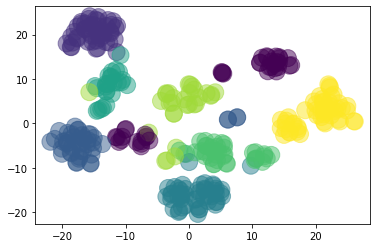

In [15]:
X = np.array(data['embediing_trf_mpnet'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_trf, s=290,alpha=.5)
plt.show()

#### Visualization using Facetgrid

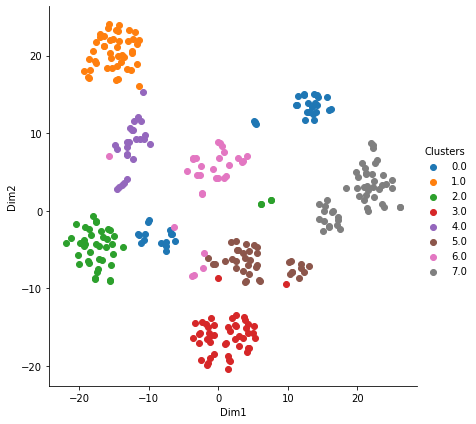

In [16]:
tnse_data=np.vstack((Y.T, cluster_trf)).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','Clusters'))

sns.FacetGrid(tsne_df, hue="Clusters", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [17]:
print(data['Label'].value_counts())
print(data['cluster_trf_mpnet'].value_counts())

Device       101
Timer         47
Calling       43
Weather       35
Alarm         28
Time          26
Corona        25
Integrity     16
Name: Label, dtype: int64
7    50
3    49
1    46
2    43
0    40
5    38
6    30
4    25
Name: cluster_trf_mpnet, dtype: int64


In [18]:
pd.set_option('display.max_rows', 500)
data[data['cluster_trf_mpnet']==4][['cleaned_text','Label','cluster_trf_mpnet']]

,cleaned_text,Label,cluster_trf_mpnet
240,set volume at 1,Device,4
241,set volume at 5,Device,4
242,set volume at 10,Device,4
243,volume to 100,Device,4
244,mute the volume,Device,4
246,as loud as possible please,Device,4
247,be quiet,Device,4
252,current volume setting,Device,4
262,turn on camera expected tts i cant do that yet press the camera or microphone button on your device to enable or disable your camera and microphone,Device,4
273,mute,Device,4


### Clustering by using KMeans


In [26]:
# silhouette analysis
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(list(data['embediing_trf_mpnet']))
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(list(data['embediing_trf_mpnet']), cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.07903099060058594
For n_clusters=3, the silhouette score is 0.10498107224702835
For n_clusters=4, the silhouette score is 0.1327100545167923
For n_clusters=5, the silhouette score is 0.15005843341350555
For n_clusters=6, the silhouette score is 0.1556781828403473
For n_clusters=7, the silhouette score is 0.1626594513654709
For n_clusters=8, the silhouette score is 0.16895225644111633


In [20]:
from sklearn.model_selection import GridSearchCV
parameters={
            'init' : ['k-means++', 'random'],
            'algorithm' : ["auto", "full", "elkan"],
            'max_iter' : [50,100,200,300],
            'n_init' : [10,20,30]
    
            }
clustering_model = KMeans(n_clusters=num_clusters,n_jobs=-1)
grid = GridSearchCV(clustering_model, cv=5, param_grid = parameters, scoring = 
    silhouette_score)

grid.fit(list(data['embediing_trf_mpnet']))
print(grid.best_params_)

{'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 50, 'n_init': 10}


In [21]:
# Perform kmean clustering
num_clusters = 8
clustering_model = KMeans(n_clusters=num_clusters,max_iter=50)
clustering_model.fit(list(data['embediing_trf_mpnet']))
cluster_assignment = clustering_model.labels_
data['k_means_clstr']=cluster_assignment

In [22]:
data.tail()

,Test Case Description,Label,cleaned_text,embediing_trf_mpnet,cluster_trf_mpnet,centroid_trf_mpnet,k_means_clstr
316,Turn up volume to 9,Device,turn up volume to 9,"[-0.06546349, -0.04650524, -0.002022576, 0.0023055936, -0.014766618, 0.04150067, -0.04654687, -0.033639163, -0.01371983, 0.038465146, -0.044608146, 0.022142626, -0.055139475, 0.03881683, 0.0076575...",4,"[-0.03793397, -0.051016033, -0.020587431, 0.006561008, -0.0077978214, 0.0020498943, -0.0010958912, -0.019221745, -0.029672243, 0.02622617, -0.0330014, -0.0045716735, -0.020657388, 0.03203922, 0.01...",3
317,turn volume down to 4,Device,turn volume down to 4,"[-0.047728084, -0.066309996, -0.027648484, 0.030231949, -0.0029409812, 0.02334556, 0.00046751782, -0.022584934, -0.018242078, 0.04535913, -0.060664576, -0.020175109, -0.046440218, 0.014350965, -0....",4,"[-0.03793397, -0.051016033, -0.020587431, 0.006561008, -0.0077978214, 0.0020498943, -0.0010958912, -0.019221745, -0.029672243, 0.02622617, -0.0330014, -0.0045716735, -0.020657388, 0.03203922, 0.01...",3
318,unmute,Device,unmute,"[-0.05403915, 0.05417607, -0.0012664514, 0.0048783696, 0.04002082, 0.046116263, 0.033999685, -0.038550243, 0.003778136, -0.0017759472, -0.02155341, 0.10827073, -0.038251445, -0.01965551, -0.059223...",6,"[-0.03255415, -0.0073243515, 0.0004747579, 0.0044051227, -0.0071208556, 0.009858321, 0.012968528, 0.0020055831, 0.01951021, -0.01996186, -0.0061234827, 0.010095138, -0.007681971, 0.04870421, 0.009...",6
319,what is the brightness,Device,what is the brightness,"[-0.021882884, -0.12531394, -0.028111342, 0.00878412, -0.051958833, -0.0042661587, -0.022641724, 0.004501706, -0.025805, 0.020092962, -0.019602308, 0.011863918, 0.011217792, 0.0336818, -0.00228472...",1,"[-0.040460505, -0.06364606, -0.041045163, 0.0015982331, -0.026796222, -0.0053953985, 9.459641e-05, 0.047449563, -0.026195742, 0.04105583, -0.018163268, 0.011561044, -0.0038872238, 0.039292816, 0.0...",0
320,what is the volume right now,Device,what is the volume right now,"[-0.061269805, -0.11497963, -0.0065325606, -0.015792467, -0.050293144, -0.019582137, -0.021793386, -0.036503952, -0.0690722, 0.050634254, -0.050535783, -0.028605863, -0.015487266, 0.074943565, -0....",4,"[-0.03793397, -0.051016033, -0.020587431, 0.006561008, -0.0077978214, 0.0020498943, -0.0010958912, -0.019221745, -0.029672243, 0.02622617, -0.0330014, -0.0045716735, -0.020657388, 0.03203922, 0.01...",3


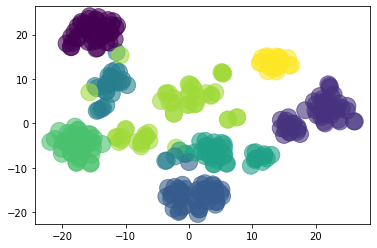

In [23]:
X = np.array(data['embediing_trf_mpnet'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_assignment, s=290,alpha=.6)
plt.show()

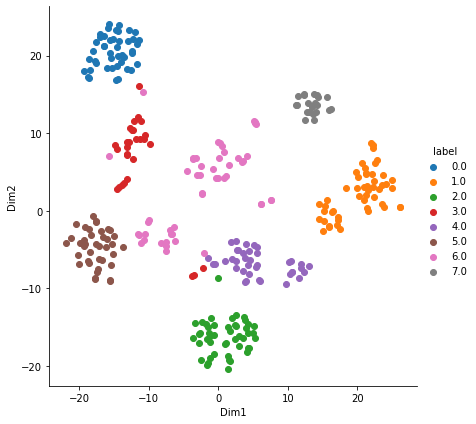

In [24]:
tnse_data=np.vstack((Y.T, cluster_assignment)).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','label'))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [25]:
print(data['Label'].value_counts())
print(data['k_means_clstr'].value_counts())

Device       101
Timer         47
Calling       43
Weather       35
Alarm         28
Time          26
Corona        25
Integrity     16
Name: Label, dtype: int64
6    51
1    50
2    48
0    45
4    39
5    39
3    28
7    21
Name: k_means_clstr, dtype: int64
